In [1]:
INPUT_SHAPE = (224, 224, 3)
THRESHOLD = 0.0008460283
DATA_DIR = '/data/cmpe257-02-fa2019/team-1-meerkats/rsna-intracranial-hemorrhage-detection/'

In [2]:
weights_file = "weights/2019-12-14-13:14:12.257939-08:00-ResNet50-conv+head-670k/2019-12-14-13:14:12.257939-08:00-ResNet50-conv+head-670k-epoch=05-valid-loss=0.07.hdf5"

In [3]:
!ls $weights_file

weights/2019-12-14-13:14:12.257939-08:00-ResNet50-conv+head-670k/2019-12-14-13:14:12.257939-08:00-ResNet50-conv+head-670k-epoch=05-valid-loss=0.07.hdf5


In [4]:
# custom loss function
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([1., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)

# custom performance metric
def correct_diagnoses(y_true, y_pred):
    THRESHOLD = 0.5
    p_thr = K.greater(y_pred, THRESHOLD)
    y_true = K.cast(y_true, dtype='bool')
    
    equals_t = K.equal(p_thr, y_true)
    correct_rows = K.all(equals_t, axis=1)
    correct_rows_int = K.cast(correct_rows, dtype='int32')
    
    return K.sum(correct_rows_int)/K.shape(correct_rows_int)[0]

def correct_positive_diagnoses(y_true, y_pred):
    THRESHOLD = 0.5
    p_thr = K.greater(y_pred, THRESHOLD)
    y_true = K.cast(y_true, dtype='bool')
    
    pos_mask = K.any(y_true, axis=1) #patients with positive diagnoses
    p_thr = p_thr[pos_mask]
    y_true = y_true[pos_mask]
    
    equals_t = K.equal(p_thr, y_true)
    correct_rows = K.all(equals_t, axis=1)
    correct_rows_float = K.cast(correct_rows, dtype='float32')
    
    return K.sum(correct_rows_float)/(K.cast(K.shape(correct_rows_float)[0], dtype='float32')+K.epsilon())

def np_cpd(y_true, pred, thr=0.5): #numpy implementation of correct positive diagnoses
    p_thr = pred > thr

    pos_mask = np.any(y_true, axis=1)

    p_thr = p_thr[pos_mask]
    y_true = y_true[pos_mask]

    p_correct = np.all(p_thr[:len(y_true)] == y_true[:len(p_thr)], axis=1)

    return np.sum(p_correct)/(len(p_thr)+1e-15)

Using TensorFlow backend.


In [5]:
import keras

model = keras.models.load_model(weights_file, custom_objects={'correct_positive_diagnoses': correct_positive_diagnoses})

















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [6]:
model

In [7]:
# dcm processing

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    #handle the 12 bit values
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def window_and_scale_brain_subdural_soft(dcm):
    
    #window images
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    #soft_img = window_image(dcm, 40, 380)
    bone_img = window_image(dcm, 600, 2800)
    
    #scale images (0-1)
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img + 20) / 200
    bone_img = (bone_img + 800) / 2800
    
    # combine channels
    return np.array([brain_img, subdural_img, bone_img]).transpose(1,2,0)

def old_window_and_scale(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img


def read_trainset(filename=DATA_DIR+"stage_2_train.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        56346,56347,56348,56349,
        56350,56351,1171830,1171831,
        1171832,1171833,1171834,1171835,
        3705312,3705313,3705314,3705315,
        3705316,3705317,3842478,3842479,
        3842480,3842481,3842482,3842483
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

In [8]:
import keras
import cv2
from math import ceil
import numpy as np
import pydicom

np.random.seed(257)

def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = window_and_scale_brain_subdural_soft(dcm)
        img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
        
    # Some dcms seem to be corrupted
    except ValueError:
        print('Error while parsing {}'.format(path))
        img = np.ones(desired_size)
    
    return img

class DataGenerator(keras.utils.Sequence):

    def __init__(self, img_dir, image_IDs, labels_df, batch_size, img_size):

        self.image_IDs = image_IDs
        self.labels_df = labels_df
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir

    def __len__(self):
        return int(ceil(len(self.image_IDs) / self.batch_size))

    def __getitem__(self, index):
        
        batch_ids = self.image_IDs[index*self.batch_size:(index+1)*self.batch_size]
        
        X = np.empty((self.batch_size, *self.img_size))
        Y = np.empty((self.batch_size, 6))
        
        for i, ID in enumerate(batch_ids):
            X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            Y[i,] = self.labels_df.loc[ID].values
        
        return X, Y

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df = read_trainset()

df = read_trainset()
train_df, test_df = train_test_split(df,test_size=0.1, random_state=257)


traingen = DataGenerator(img_dir=DATA_DIR+'stage_2_train/',
                         image_IDs=train_df.index, #MAGIC
                         labels_df=train_df, #MAGIC
                         batch_size=16,
                         img_size=INPUT_SHAPE)

testgen = DataGenerator(img_dir=DATA_DIR+'stage_2_train/',
                         image_IDs=test_df.index, #MAGIC
                         labels_df=test_df, #MAGIC
                         batch_size=16,
                         img_size=INPUT_SHAPE)

In [10]:
p = model.predict_generator(testgen)

In [11]:
len(p)

75296

In [12]:
df = read_trainset()

In [13]:
truth = np.array(testgen.labels_df, dtype='bool')

In [14]:
label_names = df['Label'].keys().to_numpy()
label_names

array(['any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural'], dtype=object)

In [65]:
import sklearn

recalls = {}
accuracies = {}
precisions = {}

for t in np.linspace(0,1,1000):
    pred = p > t
    pred = pred[:len(truth)]
    
    recalls[str(t)] = []
    accuracies[str(t)] = []
    precisions[str(t)] = []
    
    for i, lab in enumerate(label_names):
        
        # per-class recall
        recall = sklearn.metrics.recall_score(truth[:,i], pred[:,i])
        recalls[str(t)].append(recall)
        
        # per-class accuracy
        acc = sklearn.metrics.accuracy_score(truth[:,i], pred[:,i])
        accuracies[str(t)].append(acc)
        
        # per-class precision
        precision = sklearn.metrics.precision_score(truth[:,i], pred[:,i])
        precisions[str(t)].append(precision)


In [66]:
y = [v[0] for k,v in recalls.items()]
x = [1-v[0] for k,v in precisions.items()]

# Per-class recall

0.0007351637


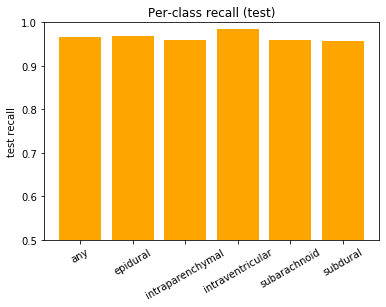

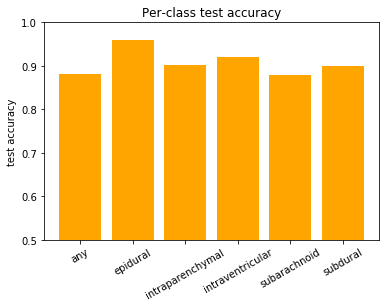

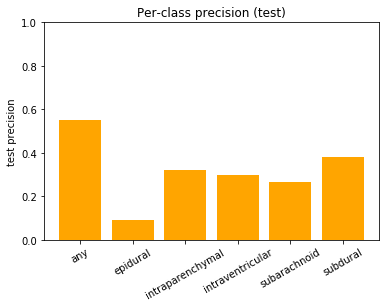

0.05


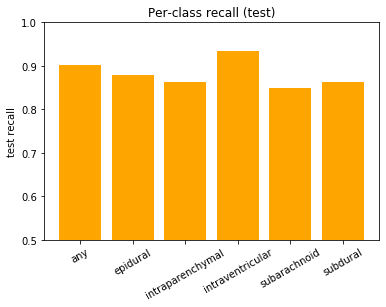

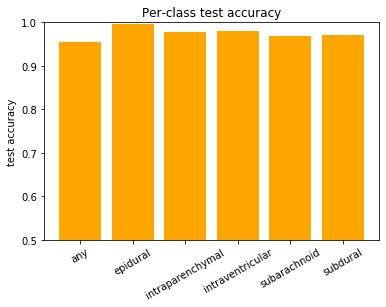

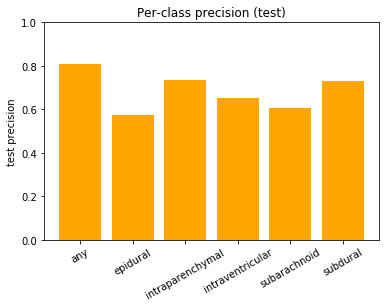

0.1


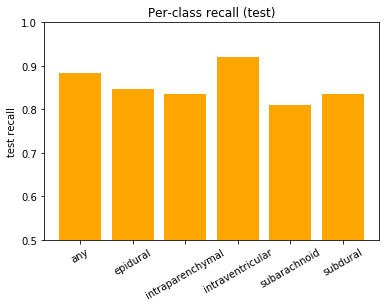

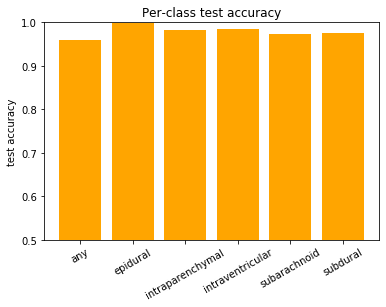

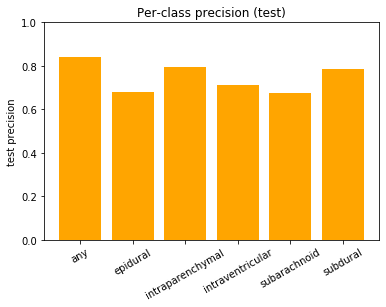

0.2


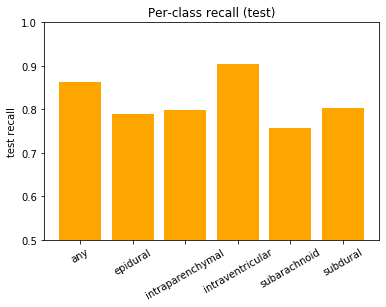

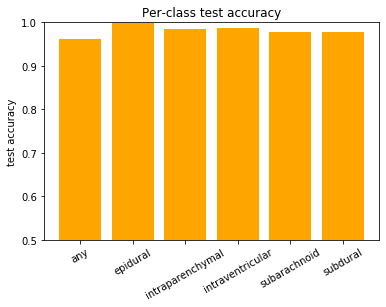

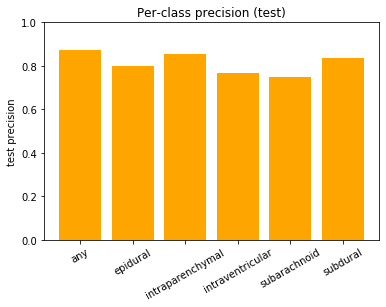

0.3


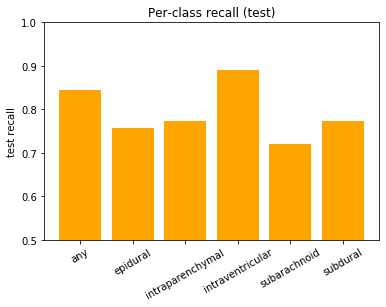

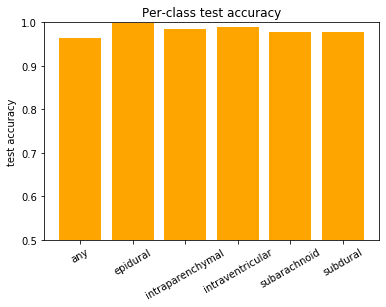

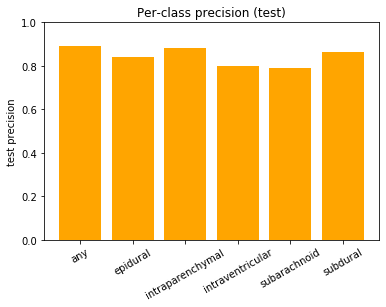

0.4


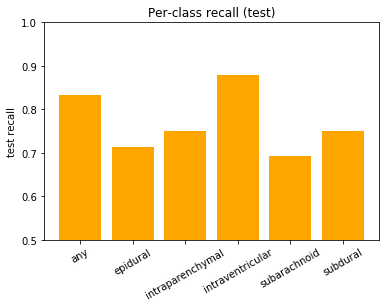

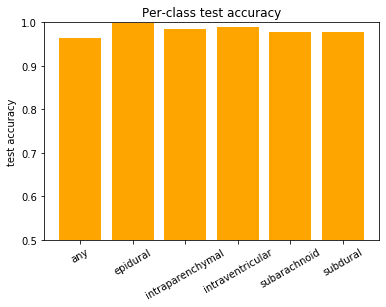

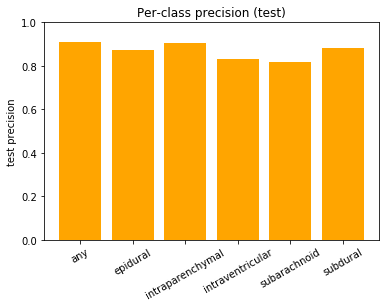

0.5


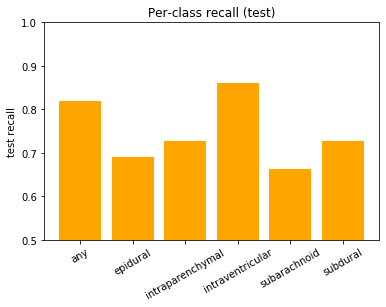

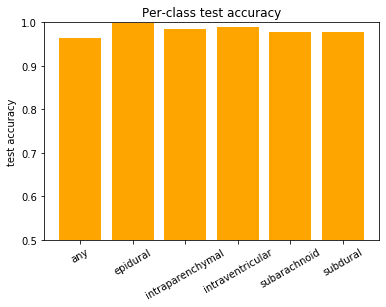

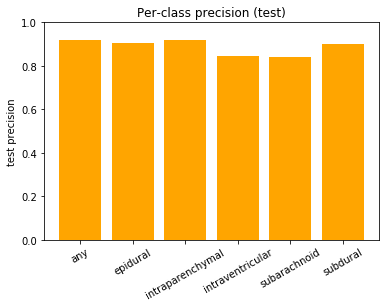

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

for threshold in recalls.keys():
    
    print(threshold)
    
    plt.figure()
    plt.title('Per-class recall (test)')
    plt.ylabel('test recall')
    plt.xticks(rotation=30)
    axes = plt.gca()
    axes.set_ylim([0.5, 1])
    plt.bar(list(df['Label']), height=recalls[threshold], color='orange')
    plt.show()

    # Per-class accuracy
    #plt.figure(figsize=(10,6))
    plt.title('Per-class test accuracy')
    plt.ylabel('test accuracy')
    plt.xticks(rotation=30)
    axes = plt.gca()
    axes.set_ylim([0.5, 1])
    plt.bar(list(df['Label']), height=accuracies[threshold], color='orange')
    plt.show()

    # Per-class precision
    plt.title('Per-class precision (test)')
    plt.ylabel('test precision')
    plt.xticks(rotation=30)
    axes = plt.gca()
    axes.set_ylim([0, 1])
    plt.bar(list(df['Label']), height=precisions[threshold], color='orange')
    plt.show()

# AUC

In [18]:
auc = sklearn.metrics.roc_auc_score(truth, pred)
auc

0.87134722509655

In [19]:
truth

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       ...,
       [False, False, False, False, False, False],
       [ True, False, False, False,  True,  True],
       [False, False, False, False, False, False]])

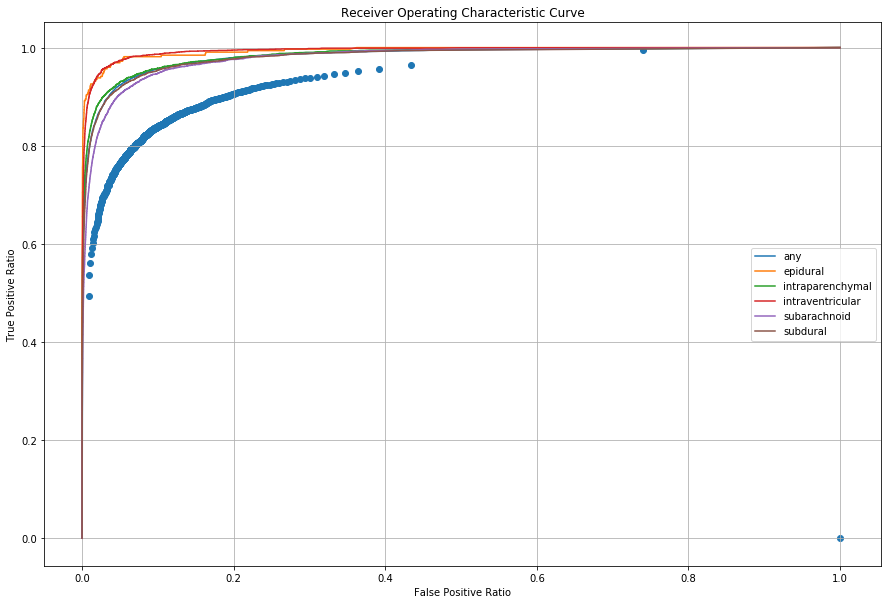

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.grid('major')

handles = []
for i, lab in enumerate(label_names):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(truth[:,i], p[0:len(truth),i], drop_intermediate = True)
    ax = plt.plot(fpr,tpr)
    handles.append(ax)

plt.scatter(x,y)
plt.legend(label_names)

In [49]:
# to save predictions
import jsonpickle
numpy_array_as_string = jsonpickle.encode(p)
with open('predictions.json',mode='w') as f:
    f.write(numpy_array_as_string)
    
recovered_p = jsonpickle.decode(numpy_array_as_string)

In [48]:
p.shape

(75296, 6)

In [23]:
np.sum(fpr < 0.1)

2460

# Any - learned or explicit predictor?

In [24]:
any_truth = testgen.labels_df['Label']['any'].values

In [25]:
any_explicit = np.array(np.sum(pred[:,1:], axis=1), dtype=np.bool)

In [26]:
any_predicted = pred[:,0]

In [27]:
# accuracy comparison
print(sklearn.metrics.accuracy_score(any_truth, any_predicted))
print(sklearn.metrics.accuracy_score(any_truth, any_explicit))

0.9638022874297631
0.9630185571392516


In [28]:
# recall comparison
print(sklearn.metrics.recall_score(any_truth, any_predicted))
print(sklearn.metrics.recall_score(any_truth, any_explicit))

0.8198508853681268
0.7962721342031687


In [29]:
# precision comparison
print(sklearn.metrics.precision_score(any_truth, any_predicted))
print(sklearn.metrics.precision_score(any_truth, any_explicit))

0.917405360308687
0.934587617589149


In [30]:
np.sum(fpr < 0.1)

2460

In [31]:
thresholds[2455]

0.0008702576

Looks like there's a lot to gain from just manipulating the threshold